In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [10]:
def generate_data(N):
    X = torch.randint(0, 9, size = (N, 10))
    num2s = torch.count_nonzero(X == 2, dim = -1)
    num4s = torch.count_nonzero(X == 4, dim = -1)
    
    labels = torch.tensor(num4s > num2s, dtype=torch.float)
    
    return X, labels.reshape(-1,1)

In [3]:
class AttentionModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.query = torch.nn.Parameter(torch.randn(1,16))
        self.embed_func = torch.nn.Embedding(10, embedding_dim=16)
        self.key_func = torch.nn.Linear(16,16)
        self.value_func = torch.nn.Sequential(
            torch.nn.Linear(16, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1)
        )

        self.head_mlp = torch.nn.Sequential(
            torch.nn.Linear(1,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,1),
            torch.nn.Sigmoid()
        )
        
    def forward(self, X):
        embedX = self.embed_func(X)
        keys = self.key_func(embedX)
        qk = torch.einsum('ie, bje -> bij', self.query, keys)
        qk = qk / 16 ** 0.5
        att = torch.nn.functional.softmax(qk, dim = -1)
        vals = self.value_func(embedX)
        summary = torch.einsum('bij, bje -> bie', att, vals)[:,0,:]
        
        pred = self.head_mlp(summary)
        return pred, att, vals

In [11]:


X, y = generate_data(123)
p, a, v = model(X)

loss = torch.nn.functional.binary_cross_entropy(p,y)
loss

/tmp/ipykernel_52121/1358409764.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(num4s > num2s, dtype=torch.float)


tensor(0.6617, grad_fn=<BinaryCrossEntropyBackward0>)

In [24]:
def train():    
    model = AttentionModel()
    opt = torch.optim.Adam(model.parameters(), lr=3e-4)
    losses = []
    for idx in range(5000):
        X, y = generate_data(123)
        p, a, v = model(X)
        loss = torch.nn.functional.binary_cross_entropy(p, y)
        losses.append(float(loss))
        if idx % 100 == 0:
            print(float(loss))
        loss.backward()
        opt.step()
        opt.zero_grad()
    return model, losses

In [25]:
model, losses = train()

/tmp/ipykernel_52121/1358409764.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(num4s > num2s, dtype=torch.float)


0.6914551258087158
0.6548766493797302
0.5811014771461487
0.27994072437286377
0.09135517477989197
0.04430391639471054
0.043505992740392685
0.03309935703873634
0.025059185922145844
0.01719018816947937
0.008731919340789318
0.006537978071719408
0.005294816102832556
0.005988921970129013
0.003917524591088295
0.002794096013531089
0.002630535513162613
0.002447138074785471
0.0019787221681326628
0.0025668845046311617
0.0008720651385374367
0.0010736575350165367
0.0008959748665802181
0.0005864142440259457
0.0005281888879835606
0.0004093476163689047
0.0007073911838233471
0.0012613276485353708
0.0004644312139134854
0.0002935567172244191
0.00040353290387429297
0.00031172996386885643
0.0003462752792984247
0.0003638708440121263
0.0008321110508404672
0.00018553510017227381
0.0003054886474274099
0.00014952768106013536
0.00022394098050426692
0.00015381415141746402
0.00023442965175490826
0.0001695618557278067
6.28484704066068e-05
0.00011436244676588103
9.651732398197055e-05
5.394821346271783e-05
8.54467143

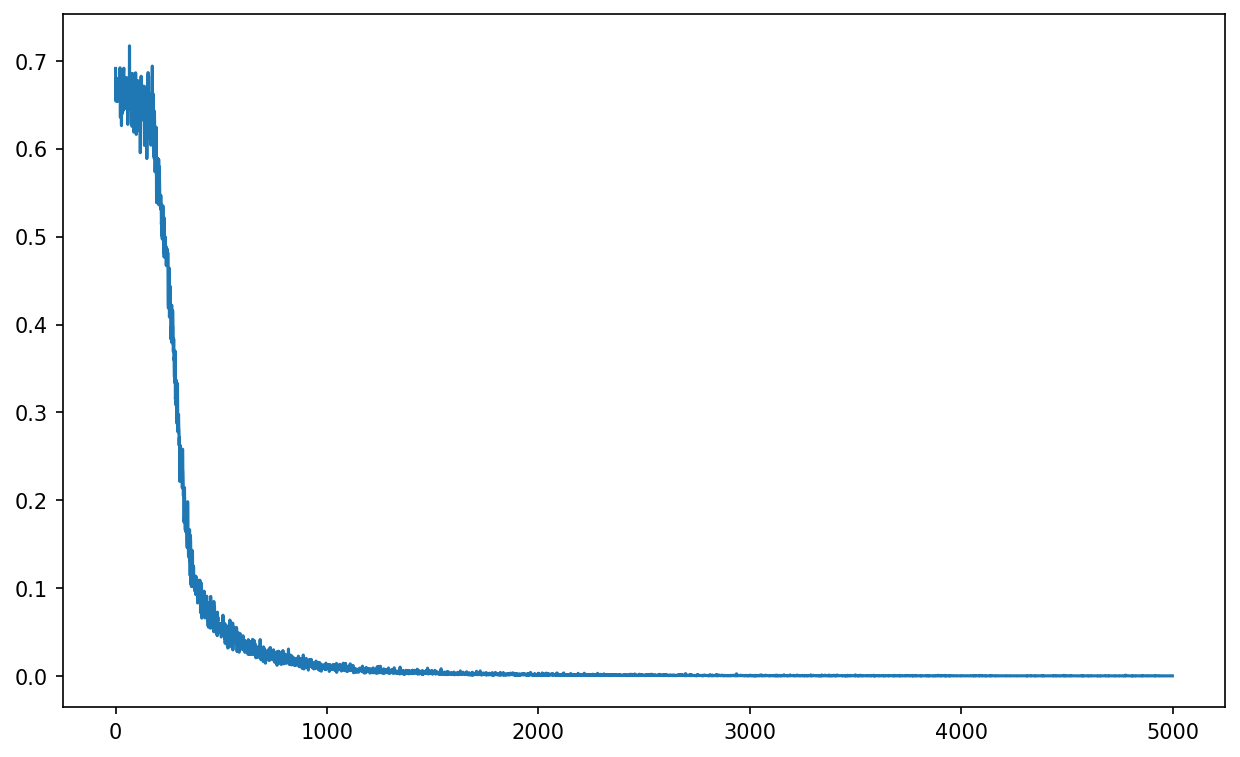

In [26]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(losses)
plt.show()

In [36]:
def decoder(x):
    return x > 0.5

In [37]:
decoder(p)

tensor([[False]])

In [46]:
with torch.no_grad():
    X = torch.LongTensor([[4, 7, 2, 2, 2, 1, 3, 4, 0, 6]])
    p, a, v = model(X)
    answer = decoder(p)

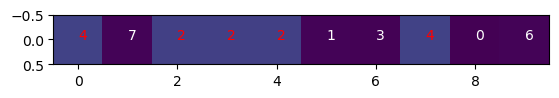

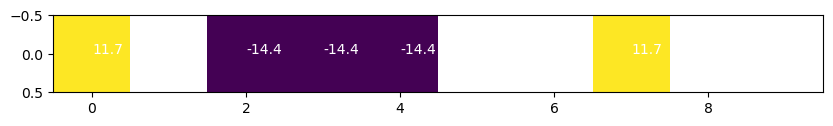

In [58]:
plt.imshow(a[0], vmin=0, vmax=1)
for x, y, d in zip(np.arange(10), np.zeros(10), X[0]):
    plt.text(x,y,int(d), c='r' if d in [4,2] else 'w')
plt.show()

msgs = v[:,:,0]
msgs = np.where(a[0] > 0.1, v[:,:,0], np.nan*v[:,:,0])
plt.imshow(msgs)
for x, y, d in zip(np.arange(10), np.zeros(10), msgs[0]):
    plt.text(x,y,f'{d:.1f}', c='w')
plt.gcf().set_size_inches(20,1)
plt.show()